In [227]:
using StatsBase, Turing, Distributions, Random, MCMCChains, Plots, StatsPlots, Measures, BSON
# Set a random seed for reproducibility
Random.seed!(1234)

TaskLocalRNG()

In [114]:
#Load posteriror samples
BSON.@load "Posterior_Samples/level2_posterior_samples_test1_mixed.bson" posterior_samples_test1_mixed
BSON.@load "Posterior_Samples/level2_posterior_samples_test2_mixed.bson" posterior_samples_test2_mixed
BSON.@load "Posterior_Samples/level2_posterior_samples_test1_uniform.bson" posterior_samples_test1_uniform
BSON.@load "Posterior_Samples/level2_posterior_samples_test2_uniform.bson" posterior_samples_test2_uniform

In [354]:
function compute_posterior_switch_probabilities(
    posterior_samples1, posterior_samples2, utility_LV, utility_HV
)
    # Hardcoded container indices for your use case
    container1_index = 11  # Test 1 corresponds to container 11
    container2_index = 12  # Test 2 corresponds to container 12

    # Get the number of samples in the specified containers
    n_samples = length(posterior_samples1[container1_index][:theta])

    # Ensure both containers have the same number of posterior draws
    if n_samples != length(posterior_samples2[container2_index][:theta])
        error("The number of samples must be the same for both containers.")
    end

    # Initialize arrays to store the posterior distributions of P_Stay and P_Switch
    P_Stay_all = Vector{Vector{Float64}}(undef, n_samples)
    P_Switch_all = Vector{Vector{Float64}}(undef, n_samples)

    # Loop through each sample in the containers
    for i in 1:n_samples
        # Extract posterior samples (vectors) for the current sample
        theta_test1 = posterior_samples1[container1_index][:theta][i]
        theta_test2 = posterior_samples2[container2_index][:theta][i]

        # Ensure both have the same number of posterior draws
        n_draws = length(theta_test1)
        P_Stay_draws = Vector{Float64}(undef, n_draws)
        P_Switch_draws = Vector{Float64}(undef, n_draws)

        # Loop through each posterior draw to compute probabilities
        for j in 1:n_draws
            # Extract the individual posterior draws for theta
            theta1_draw = theta_test1[j]
            theta2_draw = theta_test2[j]

            # Calculate utilities for the current posterior draw
            utility_test1 = exp(theta1_draw * utility_HV + (1 - theta1_draw) * utility_LV)
            utility_test2 = exp(theta2_draw * utility_HV + (1 - theta2_draw) * utility_LV)

            # Compute stay and switch probabilities for this draw
            P_Stay_draws[j] = min(1, utility_test1 / utility_test2)
            P_Switch_draws[j] = 1 - P_Stay_draws[j]
        end

        # Store the posterior distributions for this sample
        P_Stay_all[i] = P_Stay_draws
        P_Switch_all[i] = P_Switch_draws
    end

    return P_Stay_all, P_Switch_all
end

# Example usage with posterior samples
P_Stay_all, P_Switch_all = compute_posterior_switch_probabilities(
    posterior_samples_test1_mixed,  # Test 1 (container 11)
    posterior_samples_test2_mixed,  # Test 2 (container 12)
    -0.8,  # Utility for low value (LV)
    0.7   # Utility for high value (HV)
)


([[1.0, 0.8197967353163652, 1.0, 1.0, 0.8863905431265624, 0.8266998541765985, 1.0, 1.0, 1.0, 0.32086357738836885  …  1.0, 0.5639860644388995, 0.4285927078712767, 0.3949224543198006, 1.0, 0.4961028212860595, 1.0, 1.0, 0.3302626532692489, 1.0], [1.0, 0.7143942502189252, 0.6921933881256693, 1.0, 0.3971796942409196, 1.0, 0.9614667402062216, 0.7577955843310807, 0.7475879854233721, 0.5740000054544748  …  0.6335037970206467, 0.8896112499064438, 0.8841663194178174, 1.0, 0.6537270594806228, 1.0, 0.6482487329359425, 1.0, 0.4775476742971512, 1.0], [0.6132485425523414, 0.5307699754039801, 0.6375429999057601, 0.5522171302840482, 0.770020221975641, 0.5534898763644079, 0.7785219856265858, 1.0, 0.4363917854756901, 0.4281909641778424  …  0.8372090082430781, 0.8680387305464538, 0.40052477016225024, 1.0, 0.9467846460845084, 0.930313439148876, 0.41553327434562837, 1.0, 0.7437958124821656, 1.0], [0.6547067744858623, 0.7630713169304929, 0.6187028878151636, 0.6297077689064169, 0.4870251895412144, 0.676752860

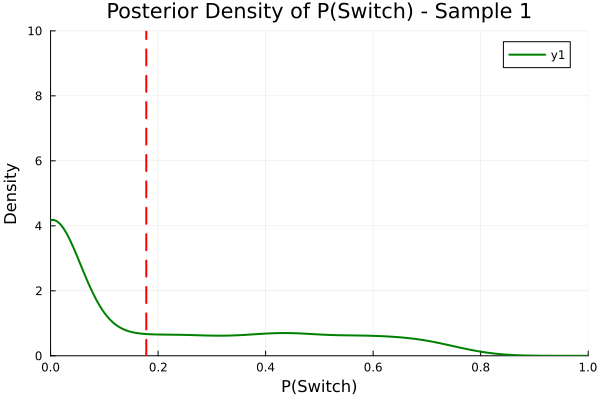

In [332]:
using Plots

# Function to plot the posterior density for P_Switch of a given sample
function plot_switch_density(P_Switch_all, sample_index)
    # Extract the posterior distribution for the given sample
    switch_posterior = P_Switch_all[sample_index]

    # Plot the density of the switch probabilities
    plot(
        switch_posterior, seriestype = :density, xlabel = "P(Switch)",
        ylabel = "Density", title = "Posterior Density of P(Switch) - Sample $sample_index",
        lw = 2, color = :green, xlims = (0, 1), ylims = (0, 10)
    )
    # Add a vertical line for the mean of the posterior distribution
    vline!([mean(switch_posterior)], color = :red, linestyle = :dash, lw = 2, label = "")
end

# Example usage for Sample 1
plot_switch_density(P_Switch_all, 1)


[ Info: Saved animation to /Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/p_switch_evolution.gif


Plots.AnimatedGif("/Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/p_switch_evolution.gif")
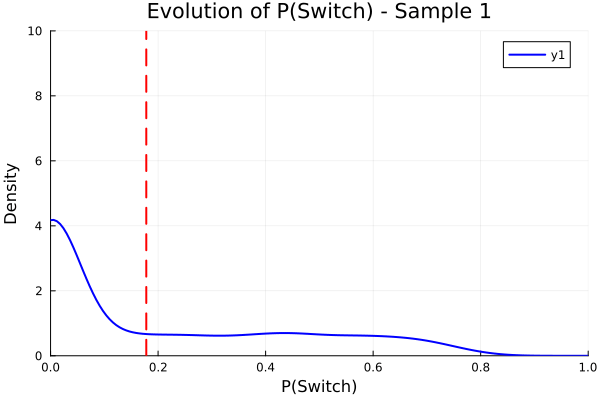

In [334]:
using Plots

# Function to animate the evolution of P_Switch across samples
function animate_switch_density(P_Switch_all)
    n_samples = length(P_Switch_all)  # Total number of samples

    # Create the animation object
    anim = @animate for i in 1:n_samples
        # Extract the posterior distribution for the current sample
        switch_posterior = P_Switch_all[i]

        # Plot the density of the switch probabilities
        p = plot(
            switch_posterior, seriestype = :density, xlabel = "P(Switch)", ylabel = "Density",
            title = "Evolution of P(Switch) - Sample $i", lw = 2, color = :blue,
            xlims = (0, 1), ylims = (0, 10)  # Adjust limits for consistent animation
        )

        # Add a vertical line for the mean of the posterior distribution
        vline!([mean(switch_posterior)], color = :red, linestyle = :dash, lw = 2, label = "")
    end

    # Save the animation as a GIF
    gif(anim, "p_switch_evolution.gif", fps = 1)
end

# Example usage
animate_switch_density(P_Switch_all)


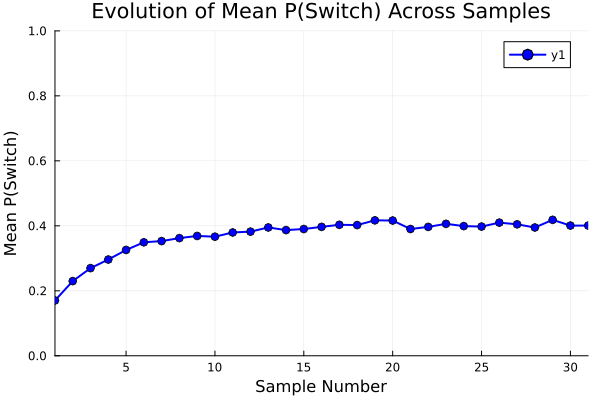

In [356]:
using Plots

# Function to extract the mean P(Switch) for each sample and plot it
function plot_switch_evolution(P_Switch_all)
    n_samples = length(P_Switch_all)  # Total number of samples

    # Compute the mean P(Switch) for each sample
    mean_P_Switch = [mean(P_Switch_all[i]) for i in 1:n_samples]

    # Plot the evolution of mean P(Switch) over samples
    plot(
        1:n_samples, mean_P_Switch, xlabel = "Sample Number", ylabel = "Mean P(Switch)",
        title = "Evolution of Mean P(Switch) Across Samples", lw = 2, marker = :o, color = :blue,
        ylims = (0, 1), xlims = (1, 31)
    )
end

# Example usage
plot_switch_evolution(P_Switch_all)


In [314]:
n_samples = length(P_Switch_all) 
lower_CI = Vector{Float64}(undef, n_samples)
upper_CI = Vector{Float64}(undef, n_samples)
lower_CI[1], upper_CI[1] = compute_ci(P_Switch_all[1])

(0.0, 0.7071442012531136)

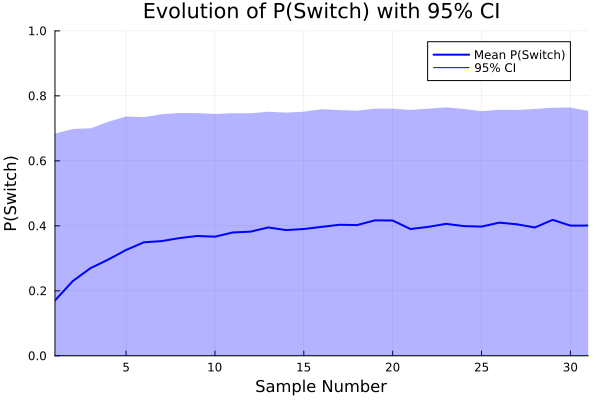

In [358]:
using Plots
using Statistics  # For mean calculation
using StatsBase   # For percentile calculation

# Function to compute confidence intervals for the switch probabilities
function compute_ci(values, lower = 2.5, upper = 97.5)
    return (percentile(values, lower), percentile(values, upper))
end

# Function to plot the evolution of P_Switch with confidence intervals
function plot_switch_evolution_with_ci(P_Switch_all)
    n_samples = length(P_Switch_all)  # Total number of samples

    # Arrays to store mean, lower, and upper confidence interval bounds
    mean_P_Switch = Vector{Float64}(undef, n_samples)
    lower_CI = Vector{Float64}(undef, n_samples)
    upper_CI = Vector{Float64}(undef, n_samples)

    # Loop over each sample to compute the mean and confidence intervals
    for i in 1:n_samples
        mean_P_Switch[i] = mean(P_Switch_all[i])
        lower_CI[i], upper_CI[i] = compute_ci(P_Switch_all[i])
    end

    # Plot the mean P(Switch) over samples with shaded confidence intervals
    plot(
        1:n_samples, mean_P_Switch, xlabel = "Sample Number", ylabel = "P(Switch)",
        title = "Evolution of P(Switch) with 95% CI", lw = 2, color = :blue, label = "Mean P(Switch)",
        ylims = (0, 1), xlims = (1, 31)
    )

    # Add the shaded confidence interval
    plot!(
        1:n_samples, lower_CI, ribbon = (upper_CI .- lower_CI), fillalpha = 0.3,
        color = :blue, label = "95% CI",
        ylims = (0, 1), xlims = (1, 31)
    )
end

# Example usage
plot_switch_evolution_with_ci(P_Switch_all)
